In [1]:
# how to deal with datasets that have
# multiple input and output features?
# i.e. if X.shape[1] > 1 or y.shape[1] > 1

In [2]:
import numpy as np
import tensorflow as tf
import tqdm
import os

In [3]:
import glob

# try and just "serialize_tensor" everything?

In [4]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a floast_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

In [5]:
X_train = np.random.normal(size=(10000, 3))
y_train = np.random.normal(size=(10000, 2))

In [6]:
X_train.shape

(10000, 3)

In [32]:
y_train.shape

(10000, 2)

In [33]:
# _bytes_feature(serialize_array(X_train))

In [5]:
def parse_single_sample(x, y):
    """
    x: X_train
    y: y_train
    """
  
    #define the dictionary -- the structure -- of our single example
    data = {
        'x' : _bytes_feature(serialize_array(x)),
        'y' : _bytes_feature(serialize_array(y)),
    }

    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [35]:
X_train[0]

array([ 0.27188252, -1.34505242,  0.5174976 ])

In [36]:
y_train[0]

array([-0.38833365,  1.71661388])

In [37]:
parse_single_sample(X_train[0], y_train[0])

features {
  feature {
    key: "x"
    value {
      bytes_list {
        value: "\010\002\022\004\022\002\010\003\"\030\0246\371\361\205f\321?\323l\356\260U\205\365\277\266F\014 W\217\340?"
      }
    }
  }
  feature {
    key: "y"
    value {
      bytes_list {
        value: "\010\002\022\004\022\002\010\002\"\020{{\342fu\332\330\277\370\223Y\035@w\373?"
      }
    }
  }
}

In [38]:
def write_training_data_to_sharded_tf_record(x, y, filename:str="test-records", max_samples_per_shard:int=10, out_dir:str="./"):
    """
    x: X_train
    y: y_train
    """

    num_samples = len(x)
    
    #determine the number of shards (single TFRecord files) we need:
    splits = (num_samples//max_samples_per_shard) + 1 #determine how many tfr shards are needed
    if num_samples%max_samples_per_shard == 0:
        splits-=1
    print(f"\nUsing {splits} shard(s) for {num_samples} samples, with up to {max_samples_per_shard} samples per shard")

    file_count = 0

    for i in tqdm.tqdm(range(splits)):
        current_shard_name = os.path.join(out_dir, "{}_{}_{}.tfrecords".format(i+1, splits, filename))
        writer = tf.io.TFRecordWriter(current_shard_name)

        current_shard_count = 0
        while current_shard_count < max_samples_per_shard: #as long as our shard is not full
            #get the index of the file that we want to parse now
            index = i*max_samples_per_shard+current_shard_count
            if index == num_samples: #when we have consumed the whole data, preempt generation
                break
    
            current_x = x[index]
            current_y = y[index]

            #create the required Example representation
            out = parse_single_sample(x=current_x, y=current_y)
    
            writer.write(out.SerializeToString())
            current_shard_count+=1
            file_count += 1

        writer.close()
    print(f"\nWrote {file_count} elements to TFRecord")
#     return file_count
    return

In [39]:
print("{} bytes".format(X_train.size * X_train.itemsize))
print("{} MB".format(X_train.size * X_train.itemsize*1e-6))
print("{} GB".format(X_train.size * X_train.itemsize*1e-9))

240000 bytes
0.24 MB
0.00024 GB


In [157]:
write_training_data_to_sharded_tf_record(X_train, y_train, filename="XY-records", max_samples_per_shard=10, out_dir="./")

100%|██████████| 10/10 [00:00<00:00, 783.72it/s]


Using 10 shard(s) for 100 samples, with up to 10 samples per shard

Wrote 100 elements to TFRecord


In [218]:
# !rm *XY*

In [161]:
!ls *XY*

10_10_XY-records.tfrecords 5_10_XY-records.tfrecords
1_10_XY-records.tfrecords  6_10_XY-records.tfrecords
1_1_XY-records.tfrecords   7_10_XY-records.tfrecords
2_10_XY-records.tfrecords  8_10_XY-records.tfrecords
3_10_XY-records.tfrecords  9_10_XY-records.tfrecords
4_10_XY-records.tfrecords


In [210]:
!du -sch *XY*

4.0K	10_10_XY-records.tfrecords
4.0K	1_10_XY-records.tfrecords
4.0K	2_10_XY-records.tfrecords
4.0K	3_10_XY-records.tfrecords
4.0K	4_10_XY-records.tfrecords
4.0K	5_10_XY-records.tfrecords
4.0K	6_10_XY-records.tfrecords
4.0K	7_10_XY-records.tfrecords
4.0K	8_10_XY-records.tfrecords
4.0K	9_10_XY-records.tfrecords
 40K	total


# version 2 - attempting to parallelise

In [40]:
# this method can take a very very long time if the input dataset is large.
# i think we should be able to parallelise this though.
# in order to do this we need to determine before hand the indicies to split the array
# i think
# https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
# will be useful

In [41]:
print(np.arange(9))
print(np.array_split(np.arange(9), 4))

[0 1 2 3 4 5 6 7 8]
[array([0, 1, 2]), array([3, 4]), array([5, 6]), array([7, 8])]


In [42]:
X_train.shape

(10000, 3)

In [43]:
# use split to get the indicies, not perform it on the actual array.

In [44]:
indicies = np.arange(len(X_train))

In [45]:
indicies

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [46]:
split_indicies = np.array_split(indicies, 10000)

In [47]:
split_indicies

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9]),
 array([10]),
 array([11]),
 array([12]),
 array([13]),
 array([14]),
 array([15]),
 array([16]),
 array([17]),
 array([18]),
 array([19]),
 array([20]),
 array([21]),
 array([22]),
 array([23]),
 array([24]),
 array([25]),
 array([26]),
 array([27]),
 array([28]),
 array([29]),
 array([30]),
 array([31]),
 array([32]),
 array([33]),
 array([34]),
 array([35]),
 array([36]),
 array([37]),
 array([38]),
 array([39]),
 array([40]),
 array([41]),
 array([42]),
 array([43]),
 array([44]),
 array([45]),
 array([46]),
 array([47]),
 array([48]),
 array([49]),
 array([50]),
 array([51]),
 array([52]),
 array([53]),
 array([54]),
 array([55]),
 array([56]),
 array([57]),
 array([58]),
 array([59]),
 array([60]),
 array([61]),
 array([62]),
 array([63]),
 array([64]),
 array([65]),
 array([66]),
 array([67]),
 array([68]),
 array([69]),
 array([70]),
 array([71]),
 a

In [48]:
len(split_indicies[0])

1

In [49]:
[len(i) for i in split_indicies]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [52]:
X_train[split_indicies[0]].shape

(1, 3)

In [53]:
X_train[split_indicies[1]].shape

(1, 3)

In [6]:
def func_to_map(i, x, y, split_indicies, filename, splits, out_dir):
    current_shard_name = os.path.join(out_dir, "{}_{}_{}.tfrecords".format(i+1, splits, filename))
    writer = tf.io.TFRecordWriter(current_shard_name)
    indicies = split_indicies[i]
    print(f"\n{i}")
    for index in indicies:
        current_x = x[index]
        current_y = y[index]
        #create the required Example representation
        out = parse_single_sample(x=current_x, y=current_y)
        writer.write(out.SerializeToString())
    writer.close()
    return i

In [7]:
from multiprocessing import Pool

In [8]:
import functools

In [9]:
def pre_chunk_write_training_data_to_sharded_tf_record(x, y, filename:str="test-records", splits:int=10, out_dir:str="./", n_cpu=1):
    """
    x: X_train
    y: y_train
    splits: number of shards
    """

    num_samples = len(x)
    
    indicies = np.arange(num_samples)
    split_indicies = np.array_split(indicies, splits)
    print(f"\nUsing {splits} shard(s) with something like {len(split_indicies[0])} samples in each shard")
    
    file_count = 0
    with Pool(n_cpu) as p:
        p.map(functools.partial(func_to_map, x=x, y=y, split_indicies=split_indicies, filename=filename, splits=splits, out_dir=out_dir), range(len(split_indicies)))

    return

In [58]:
X_train.shape

(10000, 3)

In [68]:
%%time
pre_chunk_write_training_data_to_sharded_tf_record(X_train, y_train, filename="XY-records", splits=10, out_dir="./", n_cpu=1)


Using 10 shard(s) with something like 100000 samples in each shard

0

1

2

3

4

5

6

7

8

9
CPU times: user 138 ms, sys: 168 ms, total: 306 ms
Wall time: 1min 26s


In [60]:
%%time
pre_chunk_write_training_data_to_sharded_tf_record(X_train, y_train, filename="XY-records", splits=10, out_dir="./", n_cpu=4)


Using 10 shard(s) with something like 1000 samples in each shard

0
1

2


3

4

5
6

7


8
9

CPU times: user 24.4 ms, sys: 25.8 ms, total: 50.1 ms
Wall time: 461 ms


In [11]:
# !rm *XY*

In [61]:
!ls *XY*

10_10_XY-records.tfrecords 5_10_XY-records.tfrecords
1_10_XY-records.tfrecords  6_10_XY-records.tfrecords
2_10_XY-records.tfrecords  7_10_XY-records.tfrecords
3_10_XY-records.tfrecords  8_10_XY-records.tfrecords
4_10_XY-records.tfrecords  9_10_XY-records.tfrecords


In [10]:
!du -sch *XY*

100K	10_10_XY-records.tfrecords
100K	1_10_XY-records.tfrecords
100K	2_10_XY-records.tfrecords
100K	3_10_XY-records.tfrecords
100K	4_10_XY-records.tfrecords
100K	5_10_XY-records.tfrecords
100K	6_10_XY-records.tfrecords
100K	7_10_XY-records.tfrecords
100K	8_10_XY-records.tfrecords
100K	9_10_XY-records.tfrecords
1000K	total


# load data

In [12]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'x': tf.io.FixedLenFeature([], tf.string),
      'y': tf.io.FixedLenFeature([], tf.string),
    }

    content = tf.io.parse_single_example(element, data)

    x = content['x']
    y = content['y']

    x = tf.io.parse_tensor(x, out_type=tf.float64)
    y = tf.io.parse_tensor(y, out_type=tf.float64)
    
    
    #get our 'feature'-- our image -- and reshape it appropriately
#     feature = tf.io.parse_tensor(y, out_type=tf.float32)
#     label = tf.io.parse_tensor(x, out_type=tf.float32)
#     return (feature, label)
    return (x, y)


In [13]:
def get_dataset_large(tfr_dir:str="./", pattern:str="*test-records.tfrecords"):
    print(tfr_dir+pattern)
    files = glob.glob(tfr_dir+pattern, recursive=False)
    print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(
        parse_tfr_element
    )
    
    return dataset

In [82]:
dataset_large = get_dataset_large(pattern="1_10_XY-records.*")

./1_10_XY-records.*
['./1_10_XY-records.tfrecords']


In [83]:
dataset_large

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.float64)>

In [84]:
for sample in dataset_large.take(1):
    print(sample[0])
    print(sample[1])

tf.Tensor([ 0.27188252 -1.34505242  0.5174976 ], shape=(3,), dtype=float64)
tf.Tensor([-0.38833365  1.71661388], shape=(2,), dtype=float64)


In [85]:
X_train[0]

array([ 0.27188252, -1.34505242,  0.5174976 ])

In [86]:
y_train[0]

array([-0.38833365,  1.71661388])

In [87]:
dataset_large = get_dataset_large(pattern="*XY-records.*")

./*XY-records.*
['./4_10_XY-records.tfrecords', './7_10_XY-records.tfrecords', './8_10_XY-records.tfrecords', './3_10_XY-records.tfrecords', './10_10_XY-records.tfrecords', './5_10_XY-records.tfrecords', './1_10_XY-records.tfrecords', './2_10_XY-records.tfrecords', './9_10_XY-records.tfrecords', './6_10_XY-records.tfrecords']


In [88]:
for sample in dataset_large.take(2):
    print(sample[0])
    print(sample[1])

tf.Tensor([-2.00574528  1.5511765  -1.20189689], shape=(3,), dtype=float64)
tf.Tensor([-0.38478393 -0.68080555], shape=(2,), dtype=float64)
tf.Tensor([0.10679713 0.91569621 1.18787132], shape=(3,), dtype=float64)
tf.Tensor([-0.33120033  0.88869331], shape=(2,), dtype=float64)


In [89]:
sample

(<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.10679713, 0.91569621, 1.18787132])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.33120033,  0.88869331])>)

In [94]:
xxyy = list(dataset_large.as_numpy_iterator())

In [104]:
xx = np.stack([i[0] for i in xxyy])

In [106]:
xx.shape

(10000, 3)

In [107]:
yy = np.stack([i[1] for i in xxyy])

In [108]:
yy.shape

(10000, 2)

In [130]:
np.testing.assert_array_almost_equal(np.sort(X_train, axis=0), np.sort(xx, axis=0))

In [131]:
np.testing.assert_array_almost_equal(np.sort(y_train, axis=0), np.sort(yy, axis=0))

In [112]:
import matplotlib.pyplot as plt

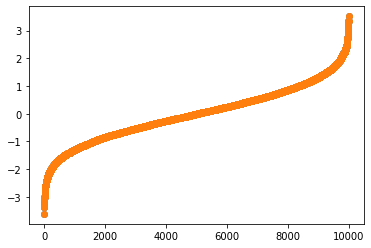

In [116]:
plt.figure()
plt.plot(np.sort(X_train[:,0]), 'o')
plt.plot(np.sort(xx[:,0]), 'o')

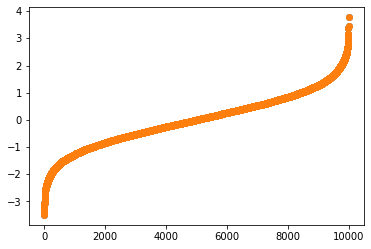

In [117]:
plt.figure()
plt.plot(np.sort(X_train[:,1]), 'o')
plt.plot(np.sort(xx[:,1]), 'o')

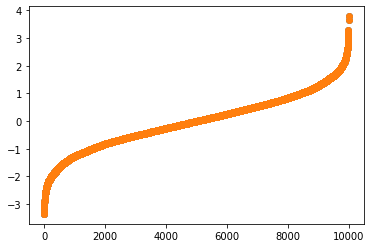

In [118]:
plt.figure()
plt.plot(np.sort(X_train[:,2]), 'o')
plt.plot(np.sort(xx[:,2]), 'o')

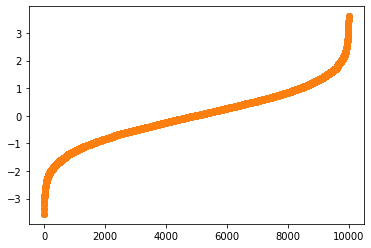

In [122]:
plt.figure()
plt.plot(np.sort(y_train[:,0]), 'o')
plt.plot(np.sort(yy[:,0]), 'o')

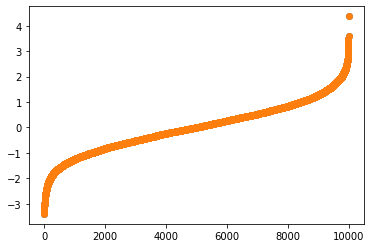

In [121]:
plt.figure()
plt.plot(np.sort(y_train[:,1]), 'o')
plt.plot(np.sort(yy[:,1]), 'o')

In [91]:
len(list(dataset_large.as_numpy_iterator()))

10000

# version 3 - similar to version 2 but only passing the sub-set of (x,y) to each proc and not the entire array

In [165]:
import uuid
print(str(uuid.uuid4())[:8])

05a4ddc4


In [176]:
data[:,:,0]

array([[-0.48643098,  0.28969535, -0.03186084,  0.18455042,  1.77972619,
        -1.2252942 ,  0.46284065,  2.44901454, -1.03867934, -1.16762454],
       [-0.03891574,  0.11652273, -1.75130562, -0.22431435, -0.3071793 ,
         0.48019449,  0.07361808,  0.71706737, -0.64829925, -0.99479873],
       [-0.10319244,  0.83674276, -1.45263337,  0.43929711,  1.81420396,
         0.06820757,  1.45802651,  1.88203181,  0.41055081,  1.66433726],
       [-0.35185419, -1.88736562,  0.66361467, -0.08313344, -1.52033978,
        -2.00290431, -1.40923769, -2.08570289,  0.81046785, -0.45157515]])

In [175]:
# example passing data as the task
data = np.random.normal(size=(4, 10, 2))
# print(data)
# 4 chunks
# each have 10 samples
# each sample is 2 dimensional

task = list(data)
# task = list((data[:,:,0], data[:,:,1]))

def test_f_map(task):
    fname = str(uuid.uuid4())[:8]

    print(f"fname: {fname}")
#     print(f"task: {task}")
    
    x = task[:,0]
    y = task[:,1]
    print(x, y)

    
with Pool(1) as p:
    p.map(test_f_map, task)

fname: 5f989b90
[-0.48643098  0.28969535 -0.03186084  0.18455042  1.77972619 -1.2252942
  0.46284065  2.44901454 -1.03867934 -1.16762454] [-0.63697314 -0.16014973  0.44257728  0.31360422 -0.60284642 -0.77606531
  0.82429677 -0.86121959  0.57536526  0.96834437]
fname: aab2a3dd
[-0.03891574  0.11652273 -1.75130562 -0.22431435 -0.3071793   0.48019449
  0.07361808  0.71706737 -0.64829925 -0.99479873] [ 0.80560427 -1.86043987  0.21926468 -0.9471579  -1.59660363  1.06008323
  0.07675066  0.62532959 -0.30084309 -0.15180265]
fname: 29647656
[-0.10319244  0.83674276 -1.45263337  0.43929711  1.81420396  0.06820757
  1.45802651  1.88203181  0.41055081  1.66433726] [-1.11405701 -1.37903706 -0.61099043  1.3304642   0.84533845 -1.1387467
 -1.006531   -0.14700751 -0.98507386 -0.13125767]
fname: c47b692d
[-0.35185419 -1.88736562  0.66361467 -0.08313344 -1.52033978 -2.00290431
 -1.40923769 -2.08570289  0.81046785 -0.45157515] [ 0.41741451 -0.61517599 -1.72759013  0.20447682 -0.69535639  0.47974357
  0.

In [294]:
def v3_func_to_map(task, filename, splits, out_dir):
    x = task[0]
    y = task[1]
    print(x.shape, y.shape)
    unique_fname = str(uuid.uuid4())[:8]
    current_shard_name = os.path.join(out_dir, "{}_of_{}_{}.tfrecords".format(unique_fname, splits, filename))
    writer = tf.io.TFRecordWriter(current_shard_name)
    print(f"\n{unique_fname}")
    for index in range(len(x)):
        current_x = x[index]
        current_y = y[index]
        #create the required Example representation
        out = parse_single_sample(x=current_x, y=current_y)
        writer.write(out.SerializeToString())
    writer.close()
    return unique_fname

In [295]:
def v3_pre_chunk_write_training_data_to_sharded_tf_record(x, y, filename:str="test-records", splits:int=10, out_dir:str="./", n_cpu=1):
    """
    x: X_train
    y: y_train
    splits: number of shards
    """

    num_samples = len(x)
    
    indicies = np.arange(num_samples)
    split_indicies = np.array_split(indicies, splits)
    print(f"\nUsing {splits} shard(s) with something like {len(split_indicies[0])} samples in each shard")
    
    x = np.array_split(x, splits)
    y = np.array_split(y, splits)
    
    task = [(x[i], y[i]) for i in range(splits)]
    
    with Pool(n_cpu) as p:
        p.map(functools.partial(v3_func_to_map, filename=filename, splits=splits, out_dir=out_dir), task)

    return

In [296]:
len(np.split(X_train, 10))

10

In [297]:
np.split(X_train, 10)[0].shape

(1000, 3)

In [298]:
X_train.shape

(10000, 3)

In [301]:
%%time
v3_pre_chunk_write_training_data_to_sharded_tf_record(X_train, y_train, filename="XY-records", splits=10, out_dir="./", n_cpu=1)


Using 10 shard(s) with something like 1000 samples in each shard
(1000, 3) (1000, 2)

61d0e932
(1000, 3) (1000, 2)

b4479297
(1000, 3) (1000, 2)

3cf6b6a0
(1000, 3) (1000, 2)

713b3706
(1000, 3) (1000, 2)

e8415519
(1000, 3) (1000, 2)

2d77877c
(1000, 3) (1000, 2)

2492be34
(1000, 3) (1000, 2)

fd77b68b
(1000, 3) (1000, 2)

d7a02ae8
(1000, 3) (1000, 2)

42fb2216
CPU times: user 29.8 ms, sys: 24 ms, total: 53.8 ms
Wall time: 1.24 s


In [302]:
# !rm *XY*

In [303]:
!ls *XY*

2492be34_of_10_XY-records.tfrecords 713b3706_of_10_XY-records.tfrecords
2d77877c_of_10_XY-records.tfrecords b4479297_of_10_XY-records.tfrecords
3cf6b6a0_of_10_XY-records.tfrecords d7a02ae8_of_10_XY-records.tfrecords
42fb2216_of_10_XY-records.tfrecords e8415519_of_10_XY-records.tfrecords
61d0e932_of_10_XY-records.tfrecords fd77b68b_of_10_XY-records.tfrecords


In [304]:
!du -sch *XY*

100K	2492be34_of_10_XY-records.tfrecords
100K	2d77877c_of_10_XY-records.tfrecords
100K	3cf6b6a0_of_10_XY-records.tfrecords
100K	42fb2216_of_10_XY-records.tfrecords
100K	61d0e932_of_10_XY-records.tfrecords
100K	713b3706_of_10_XY-records.tfrecords
100K	b4479297_of_10_XY-records.tfrecords
100K	d7a02ae8_of_10_XY-records.tfrecords
100K	e8415519_of_10_XY-records.tfrecords
100K	fd77b68b_of_10_XY-records.tfrecords
1000K	total


In [305]:
dataset_large = get_dataset_large(pattern="*of*_XY-records.*")

./*of*_XY-records.*
['./fd77b68b_of_10_XY-records.tfrecords', './713b3706_of_10_XY-records.tfrecords', './d7a02ae8_of_10_XY-records.tfrecords', './2492be34_of_10_XY-records.tfrecords', './b4479297_of_10_XY-records.tfrecords', './61d0e932_of_10_XY-records.tfrecords', './42fb2216_of_10_XY-records.tfrecords', './2d77877c_of_10_XY-records.tfrecords', './3cf6b6a0_of_10_XY-records.tfrecords', './e8415519_of_10_XY-records.tfrecords']


In [306]:
xxyy = list(dataset_large.as_numpy_iterator())

In [307]:
xx = np.stack([i[0] for i in xxyy])

In [308]:
xx.shape

(10000, 3)

In [309]:
yy = np.stack([i[1] for i in xxyy])

In [310]:
yy.shape

(10000, 2)

In [311]:
np.testing.assert_array_almost_equal(np.sort(X_train, axis=0), np.sort(xx, axis=0))

In [312]:
np.testing.assert_array_almost_equal(np.sort(y_train, axis=0), np.sort(yy, axis=0))